# Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## Data

We will use Caltech 101 dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images.

In [1]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xvzf ./101_ObjectCategories.tar.gz

In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install --user annoy

     |████████████████████████████████| 25.0MB 1.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 163kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 645kB 4.4MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297335 sha256=f416e1281b498548716ec26fb60ca05d8b2ba2200496d38a73444c8638246693
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


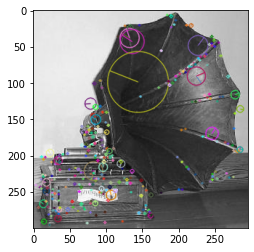

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = './101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)


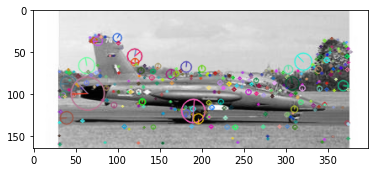

In [2]:
img = cv.imread(img_dir + '/airplanes/image_0001.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## Task 1. Index keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, we will index descriptors of all images using some datastructure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a query image we generate its descriptors, and for each of them find its k nearest neighbors (using Euclidean or Cosine distance). Finally, we sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors.



Read all images, saving category information. For every image generate SIFT descriptors and index them using some datastructure for inexact nearest neighbors search, e.g., I am using HNSW from [`nmslib`](https://github.com/nmslib/nmslib).

In [8]:
import tqdm, os
from annoy import AnnoyIndex

images_paths = [os.path.join(d, x)
              for d, dirs, files in os.walk(img_dir)
              for x in files if x.endswith(".jpg")]

index = AnnoyIndex(128, 'angular') 
i = 0
image_mapping = {}
for img_path in tqdm.tqdm_notebook(images_paths):
    img = cv.imread(img_path)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    if des is None: continue
    for (_,descript) in sorted(zip(kp,des),key = lambda x : x[0].response,reverse=True)[:100]:
        index.add_item(i, descript)
        i += 1
        image_mapping[i] = img_path

index.build(50)
index.save('index.ann')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


True

## Task 2. Find similar and evaluate

Now, having index calculated, let's pick **one image from each category** (**the first one**, for sync), and find its **10** most similar images among all images. When submitting, please **only include the output of similar images for the "accordion" category**, as demonstrated below, so that the notebook doesn't grow too big.

If a similar image belongs to the same category, we consider it as a hit. At last, compute and print the accuracy - the number of hits over total possible number of hits.

In [0]:
from collections import Counter
query = './101_ObjectCategories/accordion/image_0001.jpg'
query_img = cv.imread(query)
query_gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
query_kp, query_descriptors = sift.detectAndCompute(query_gray,None)

result = []
for query_descriptor in query_descriptors:
    des_match = index.get_nns_by_vector(query_descriptor, 100)
    result += des_match

result = Counter(result)
result_names = list(map(lambda x : image_mapping.get(x[0]), result.most_common(10)))

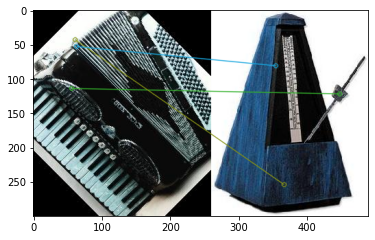

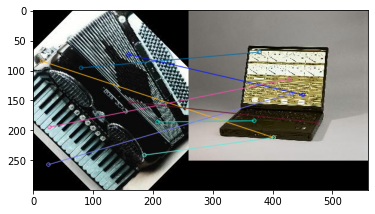

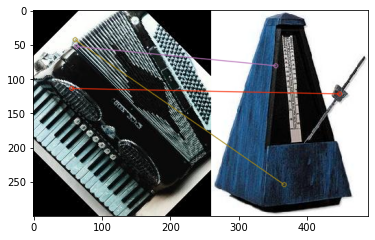

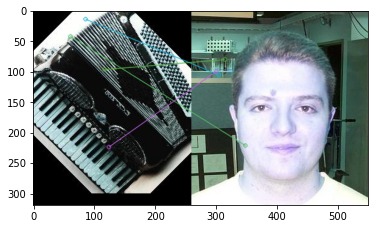

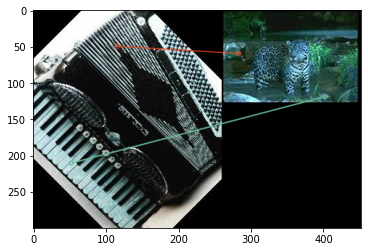

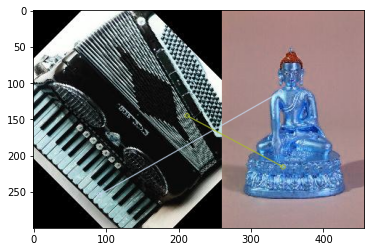

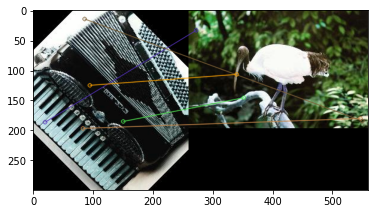

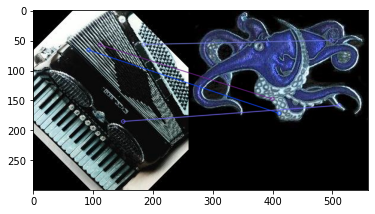

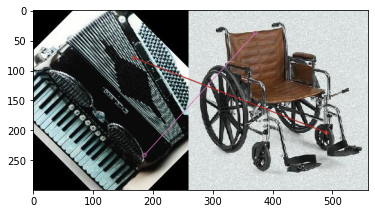

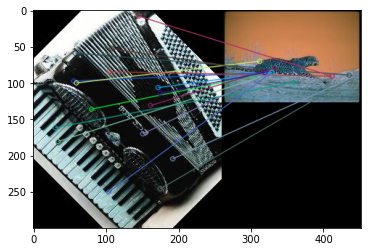

Accuracy :  0.0


In [7]:
# Plot
hit = 0
bf = cv.BFMatcher()
for r in result_names:
    img2 = cv.imread(r)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params

    if r.split('/')[2] == query.split('/')[2]: hit += 1

    matches = bf.knnMatch(query_descriptors,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(query_img,query_kp,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()

print('Accuracy : ', hit/10)